# Setup
Click the file icon on the left, then the upload file icon in the panel. Upload `implicit_hate_train.csv`, `implicit_hate_dev.csv`, and `implicit_hate_test.csv`

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd

In [3]:
from imblearn.under_sampling import RandomUnderSampler

In [4]:
folder = '/content/drive/MyDrive/CIS 530 project/'

In [5]:
import sys
sys.path.append(folder)

In [6]:
major_label_2_idx = {'not_hate' : 0, 'implicit_hate': 1, 'explicit_hate' : 2}
major_idx_2_label = {0: 'not_hate', 1:'implicit_hate',2:'explicit_hate'}


major_class_train_data = pd.read_csv(folder+"implicit_hate_train.csv")
major_class_dev_data = pd.read_csv(folder+"implicit_hate_dev.csv")
major_class_test_data = pd.read_csv(folder+"implicit_hate_test.csv")

for df in [major_class_train_data,major_class_dev_data,major_class_test_data]:
  df['labels'] = df['class'].apply(lambda x: major_label_2_idx[x])
print("major_class relevant keys: `post`, `class`")
print("  post: the tweet (str)")
print("  class: takes the values `explicit_hate`, `implicit_hate`, or `not_hate` (str)")

major_class relevant keys: `post`, `class`
  post: the tweet (str)
  class: takes the values `explicit_hate`, `implicit_hate`, or `not_hate` (str)


In [7]:
minor_label_2_idx = {'incitement':0,'inferiority':1,'irony':2,'stereotypical':3,'threatening':4,'white_grievance':5,'other':6}
minor_idx_2_label = {0:'incitement', 1:'inferiority',2:'irony', 3:'stereotypical',4:'threatening',5:'white_grievance',6:'other'}


minor_class_train_data = major_class_train_data[major_class_train_data['implicit_class'].notnull()].reset_index(drop=True)
minor_class_dev_data = major_class_dev_data[major_class_dev_data['implicit_class'].notnull()].reset_index(drop=True)
minor_class_test_data = major_class_test_data[major_class_test_data['implicit_class'].notnull()].reset_index(drop=True)

for df in [minor_class_train_data,minor_class_dev_data,minor_class_test_data]:
  df['labels'] = df['implicit_class'].apply(lambda x: minor_label_2_idx[x])

print("minor_class relevant keys: `post`, `implicit_class`")
print("  post: the tweet (str)")
print("  implicit_class: takes the values `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, or `white_grievance` (str)")

minor_class relevant keys: `post`, `implicit_class`
  post: the tweet (str)
  implicit_class: takes the values `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, or `white_grievance` (str)


In [8]:
major_class_train_data

,Unnamed: 0,post,class,implicit_class,labels
0,19809,"great. go volunteer, take your family with you...",implicit_hate,irony,1
1,9762,modern definition of racist : any white person...,implicit_hate,irony,1
2,13230,god those darn white devils getting jobs prom...,implicit_hate,irony,1
3,19799,"oh but """"evil"""" gulf countries are just sooo m...",implicit_hate,irony,1
4,21231,how did the jewish kid cheat on his math test ...,implicit_hate,irony,1
...,...,...,...,...,...
16431,3941,any proof that they're white supremacists ?,not_hate,NaN,0
16432,17439,you know the german gov't led by merkel agrees...,not_hate,NaN,0
16433,14025,another white supremacist race soldier huh,not_hate,NaN,0
16434,13616,the realist report bella dashwood #makeamerica...,not_hate,NaN,0


In [9]:
major_rus = RandomUnderSampler()
major_train_balanced, _ = major_rus.fit_resample(major_class_train_data,major_class_train_data['labels'])

minor_rus = RandomUnderSampler()
minor_train_balanced, _ = minor_rus.fit_resample(minor_class_train_data,minor_class_train_data['labels'])

In [34]:
minor_class_train_data['implicit_class'].value_counts()

white_grievance    1206
incitement          992
stereotypical       884
inferiority         687
irony               636
threatening         532
Name: implicit_class, dtype: int64

In [33]:
minor_train_balanced['implicit_class'].value_counts()

incitement         532
inferiority        532
irony              532
stereotypical      532
threatening        532
white_grievance    532
Name: implicit_class, dtype: int64

## Testing BERT finetuning levels

In [10]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import wandb

In [14]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mpressi (cis530-project). Use `wandb login --relogin` to force relogin


True

In [15]:
wandb.init(project="test-project", entity="cis530-project")

In [16]:
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader
import datasets #huggingface
from transformers import BertTokenizer, BertModel, BertForSequenceClassification#DistilBertModel, DistilBertTokenizer #change to model type you want, e.g. Bert or AlBert
from evaluation import *

In [17]:
import torch.nn as nn

In [18]:
from tqdm.autonotebook import tqdm

In [19]:
import torch.nn.functional as F

In [20]:
from transformers import Trainer, TrainingArguments

In [21]:
def tokenize(data):
    return tokenizer(data['post'], truncation=True,padding='max_length')
def tokenize_dataset(dataset,tokenizer):
    return dataset.map(tokenize,batched=True)


In [22]:
#if needed, change the tokenizer here, this is used in the function to get CLS embeddings
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") #not worried about uppercase vs lowercase
#bert = BertModel.from_pretrained("bert-base-uncased") #if needed, change model here
#bert = BertForSequenceClassification.from_pretrained("bert-base-uncased")

In [23]:
#use pandas instead to map the classes

In [24]:
"""
#used to make datasets and dataloaders.
#x = non-tokenized text
#y = labels
class ImplicitHateDataset(Dataset):
  def __init__(self,text,labels):
    self.x = text
    self.y = labels
  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    
    return self.x[idx],self.y[idx]
"""

'\n#used to make datasets and dataloaders.\n#x = non-tokenized text\n#y = labels\nclass ImplicitHateDataset(Dataset):\n  def __init__(self,text,labels):\n    self.x = text\n    self.y = labels\n  def __len__(self):\n    return len(self.y)\n  def __getitem__(self,idx):\n    \n    return self.x[idx],self.y[idx]\n'

In [25]:
class FineTunedBertModel(nn.Module):
  def __init__(self,bert_model, output_size):
    super(FineTunedBertModel,self).__init__()
    self.bert = bert_model
    self.dropout = nn.Dropout(p=0.1)
    self.ff1 = nn.Linear(768,768)
    self.feedforward = nn.Linear(768,output_size)
    self.relu = nn.ReLU()
  
  def forward(self,input_ids,attention_mask,token_type_ids):
    embeddings = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     token_type_ids=token_type_ids).last_hidden_state
    non_cls_embedding_mean = torch.mean(embeddings[:,1:,:],1)
    logits = self.feedforward(self.dropout(self.relu(self.ff1(self.dropout(non_cls_embedding_mean)))))
    return logits

In [26]:
class AverageBert():
  def __init__(self,tokenizer,label_name,num_unfrozen_layers,epochs,lr,device):
    if label_name == 'class':
      self.label_2_idx = {'not_hate' : 0, 'implicit_hate': 1, 'explicit_hate' : 2}
      self.idx_2_label = {0: 'not_hate', 1:'implicit_hate',2:'explicit_hate'}
      output_size = 3
      
    elif label_name == 'implicit_class':
      self.label_2_idx = {'incitement':0,'inferiority':1,'irony':2,'stereotypical':3,'threatening':4,'white_grievance':5,'other':6}
      self.idx_2_label = {0:'incitement', 1:'inferiority',2:'irony', 3:'stereotypical',4:'threatening',5:'white_grievance',6:'other'}
      output_size = 6
      
    self.label2idx_func = np.vectorize(lambda x: self.label_2_idx[x])
    self.idx2label_func = np.vectorize(lambda x: self.idx_2_label[x])
      
    self.tokenizer = tokenizer
    
    self.label_name = label_name
    
    self.bert = BertModel.from_pretrained("bert-base-uncased",num_labels=output_size).to(device)
    self.finetuned_bert = FineTunedBertModel(self.bert,output_size=output_size).to(device)

    self.epochs = epochs
    self.lr = lr

    num_bert_layers = len(self.finetuned_bert.bert.encoder.layer)

    """
    #make sure num_unfrozen is valid, if not make it 0
    #see: https://discuss.huggingface.co/t/how-to-freeze-some-layers-of-bertmodel/917
    unfrozen_layers = num_unfrozen_layers
    if num_unfrozen_layers not in range(num_bert_layers-1):
      print('invalid number of layers specified, will freeze all of Bert')
      unfrozen_layers = 0
    for param in self.finetuned_bert.bert.encoder.layer[:num_bert_layers - unfrozen_layers-1].parameters():
      param.requires_grad = False
    

    
      output_size = 6
    """
  def tokenize(self,data):
    return self.tokenizer(data['post'],padding='max_length')
  def tokenize_dataset(self,dataset):
    return dataset.map(self.tokenize,batched=True)

  def preprocess(self, data, is_train):
    #is_train: boolean whether or not we're working on the training set, to shuffle it.
    
    hf_dataset = datasets.Dataset.from_pandas(data[['post','labels']])
    print('Tokenizing data:')
    hf_dataset = self.tokenize_dataset(hf_dataset)
    #hf_dataset = hf_dataset.remove_columns(['post'])
    hf_dataset.set_format('torch')
    #label_name is class or implicit_class
    loader = DataLoader(hf_dataset, shuffle=is_train, batch_size=12)
    return loader
  def train(self,data):
    self.finetuned_bert.train()
    loader = self.preprocess(data,True)
    epochs = self.epochs
    learning_rate = self.lr
    #[p for p in model.parameters() if p.requires_grad()]
    optimizer = torch.optim.Adam(self.finetuned_bert.parameters(),lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    wandb.init(config={
        "epochs":epochs,
        "batch_size":12,
        "learning_rate":learning_rate
    }
    
    )

    config = wandb.config

    for epoch in range(epochs):
      print('Training epoch:',epoch+1)
      running_loss = 0
      #progress_bar = tqdm(range(len(loader)))
      for batch in tqdm(loader):
        optimizer.zero_grad()
        #print(batch)
        labels = batch['labels'].to(device)
        data = {k: v for k, v in batch.items() if k != 'labels' and k!= 'post'}
        #print(data)
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)

        
        logits = self.finetuned_bert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     token_type_ids=token_type_ids).to(device)
        
        loss = criterion(logits,labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        wandb.log({"loss":loss.item()})
        #progress_bar.update(1)
      running_loss /=len(loader)
      wandb.log({"running_loss":running_loss})
      print('Loss for epoch',(epoch+1),':',running_loss)
    wandb.finish()

  def predict(self,data):
    self.finetuned_bert.eval()
    loader = self.preprocess(data,False)
    all_predictions = None
    for batch in loader:
      
      labels = batch['labels'].to(device)
      data = {k: v for k, v in batch.items() if k != 'labels' and k!= 'post'}
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      token_type_ids = data['token_type_ids'].to(device)

        
      logits = self.finetuned_bert(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
      predicted = torch.argmax(logits,dim=1)
      if all_predictions is None:
        all_predictions = predicted.detach().cpu().numpy()
      else:
        all_predictions = np.concatenate((all_predictions,predicted.detach().cpu().numpy()),axis=0)
    return self.idx2label_func(all_predictions)

In [27]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Testing with ALL of Bert unfrozen

In [28]:
epochs = 10
lr = 2e-6
num_unfrozen_layers = 12

#major_model = FineTunedClassifier(tokenizer,bert,"class",256,0,None)
major_class_model = AverageBert(tokenizer,"class",num_unfrozen_layers,epochs,lr,device)


minor_class_model = AverageBert(tokenizer,"implicit_class",num_unfrozen_layers,epochs,lr,device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bi

Tokenizing data:


  0%|          | 0/3 [00:00<?, ?ba/s]

Training epoch: 1


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 1 : 1.0904933394642051
Training epoch: 2


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 2 : 1.029292294191658
Training epoch: 3


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 3 : 0.8723756304574669
Training epoch: 4


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 4 : 0.7516763915709399
Training epoch: 5


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 5 : 0.6756368576113237
Training epoch: 6


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 6 : 0.5996300859735646
Training epoch: 7


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 7 : 0.5408280823345578
Training epoch: 8


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 8 : 0.4673661976505857
Training epoch: 9


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 9 : 0.42009711877331823
Training epoch: 10


  0%|          | 0/218 [00:00<?, ?it/s]

Loss for epoch 10 : 0.3518475303682712


loss,███████▇▇▆▅▅▆▄▅▅▄▇▄▄▄▄▄▅▄▂▂▃▃▄▃▃▃▃▁▂▂▂▂▃
running_loss,█▇▆▅▄▃▃▂▂▁
loss,0.28404
running_loss,0.35185


Tokenizing data:


  0%|          | 0/3 [00:00<?, ?ba/s]

f1 score for class: 0.467810551537638


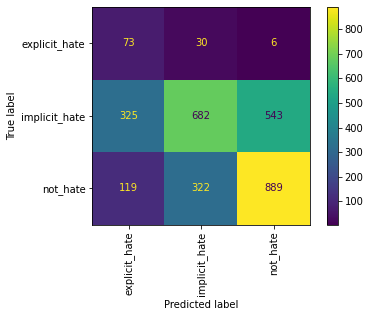

In [29]:
train_and_evaluate(major_class_model, major_train_balanced, major_class_test_data, "class")

In [38]:
major_dev_rebalanced,_ = RandomUnderSampler().fit_resample(major_class_dev_data,major_class_dev_data['labels'])

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

Tokenizing data:


  0%|          | 0/1 [00:00<?, ?ba/s]

f1 score for class: 0.6427235125348333


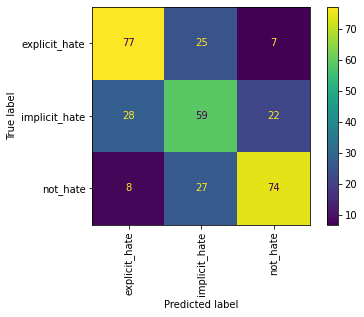

In [40]:
inference = major_class_model.predict(major_dev_rebalanced)
ConfusionMatrixDisplay.from_predictions(major_dev_rebalanced['class'], inference, xticks_rotation="vertical")
print(f"f1 score for {'class'}: {get_f1_score(major_dev_rebalanced['class'], inference)}")

In [35]:
evaluate(major_class_model, major_class_test_data, "class")

NameError: ignored

Tokenizing data:


  0%|          | 0/4 [00:00<?, ?ba/s]

Training epoch: 1


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 1 : 1.7440446655553086
Training epoch: 2


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 2 : 1.473859030949442
Training epoch: 3


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 3 : 1.2889974565434277
Training epoch: 4


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 4 : 1.15618497133255
Training epoch: 5


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 5 : 1.0413639700054227
Training epoch: 6


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 6 : 0.9397042625604716
Training epoch: 7


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 7 : 0.8529424359251682
Training epoch: 8


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 8 : 0.7664141409603277
Training epoch: 9


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 9 : 0.6935710287968019
Training epoch: 10


  0%|          | 0/266 [00:00<?, ?it/s]

Loss for epoch 10 : 0.6195326428440281


loss,████▇▇▆▆▄▅▇▅▅▅▄▄▅▄▅▆▂▂▄▃▆▄▂▅▂▃▃▃▃▃▃▆▂▁▂▂
running_loss,█▆▅▄▄▃▂▂▁▁
loss,0.37826
running_loss,0.61953


Tokenizing data:


  0%|          | 0/1 [00:00<?, ?ba/s]

f1 score for implicit_class: 0.49270852353233113


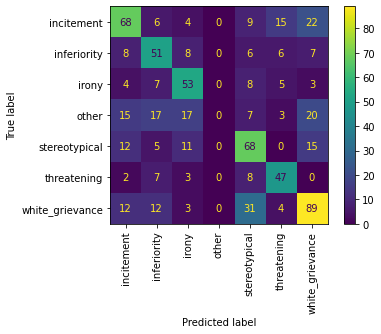

In [30]:
train_and_evaluate(minor_class_model, minor_train_balanced, minor_class_test_data, "implicit_class")

A look at the bert encoder layers to see the architecture

In [31]:
print(minor_class_model.finetuned_bert.bert.encoder)

BertEncoder(
  (layer): ModuleList(
    (0): BertLayer(
      (attention): BertAttention(
        (self): BertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       